# Transactions cleaning

In [74]:
import os
import pandas as pd
import numpy as np
from collections import Counter

# Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Garbage collector
import gc
gc.enable()

### Import the dataframes

### historical_transactions_df

In [2]:
historical_transactions_df = pd.read_csv("historical_transactions.csv")
historical_transactions_df.shape

(29112361, 14)

In [7]:
historical_transactions_df.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

### new_transactions_df

In [4]:
new_transactions_df = pd.read_csv("new_merchant_transactions.csv")
new_transactions_df.shape

(1963031, 14)

In [5]:
new_transactions_df.isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

### merged dataframes

In [83]:
transactions_df = pd.concat([historical_transactions_df, new_transactions_df])
transactions_df.shape

(31075392, 14)

### Plot functions

In [7]:
def cat_plot(df, col, df_name="", color='green'):
    cnt_srs = df[col].value_counts()
    cnt_srs = cnt_srs.sort_index()
    
    # Size check to avoid endless plots
    if(len(cnt_srs) > 500):
        print("WARNING: There are %d different catecogies" % len(cnt_srs))
        return
    plt.figure(figsize=(14,6))
    sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color)
    plt.xticks(rotation='vertical')
    title = df_name + "\n" +col
    plt.title(title)
    plt.show()

In [8]:
def dens_plot(df, col, df_name="", color='red'):
    cnt_srs = df[col].value_counts()
    cnt_srs = cnt_srs.sort_index()
    plt.figure(figsize=(14,6))
    sns.kdeplot(cnt_srs.index, shade=True, color=color)
    plt.xticks(rotation='vertical')
    title = df_name + "\n" +col
    plt.title(title)
    plt.show()

In [44]:
def joint_dens_plot(df, col, df_name=""):
    cnt_srs = df[col].value_counts()
    cnt_srs = cnt_srs.sort_index()
    
    # Size check to avoid endless plots
    if(len(cnt_srs) > 500):
        print("WARNING: There are %d different catecogies" % len(cnt_srs))
        return
    
    plt.figure(figsize=(14,6))
    sns.jointplot(cnt_srs.index, cnt_srs.values, kind="kde")
    plt.xticks(rotation='vertical')
    title = df_name + "\n" +col
    plt.title(title)
    plt.show()

### Feature cleaning

#### authorized_flag

There are 2 different categories: 
Counter({True: 28558483, False: 2516909})


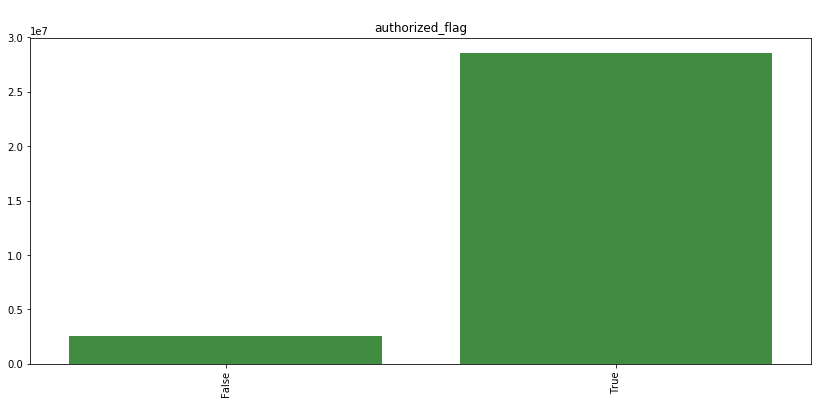

In [13]:
print("There are %d different categories: " % transactions_df['authorized_flag'].nunique())
print(Counter(transactions_df['authorized_flag']))
cat_plot(transactions_df, "authorized_flag")

In [84]:
# Change to boolean
transactions_df = transactions_df.replace({'authorized_flag': {'Y': True, 'N': False}})

#### card_id

In [12]:
print("Historical transactions set has %d different card_id" % len(set(historical_transactions_df.card_id.unique())))
print("New transactions set has %d different card_id" % len(set(new_transactions_df.card_id.unique())))
print("Number of common card_id in historical and new transactions set: %d" % (len(set(historical_transactions_df.card_id.unique()).intersection(set(new_transactions_df.card_id.unique())))))

Historical transactions set has 325540 different card_id
New transactions set has 290001 different card_id
Number of common card_id in historical and new transactions set: 290001


Train and test have not common card_id, and their total amount of different card_id is 325540.
This implies that the concatenation of historical and new transactions dataframes is mandatory in order to avoid a lot of free nans.

#### city_id

There are 308 different categories: 


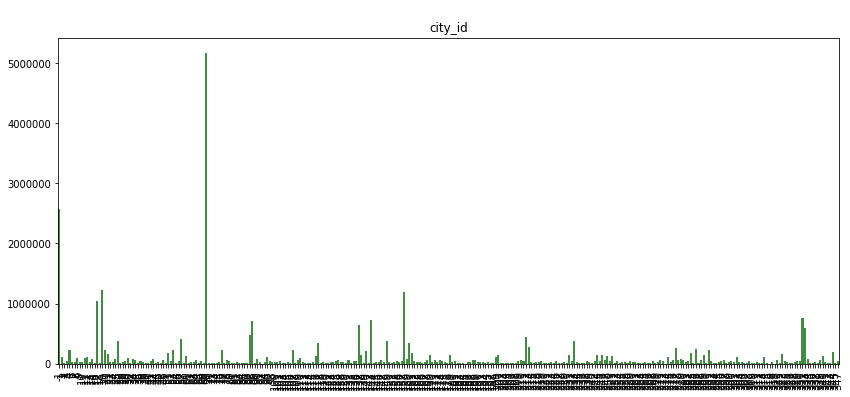

In [16]:
print("There are %d different categories: " % transactions_df['city_id'].nunique())
# print(Counter(transactions_df['city_id'])) # Too many values
cat_plot(transactions_df, "city_id")

In [26]:
print("There are %d values set to -1" % transactions_df[transactions_df['city_id']<1].city_id.count())

There are 2577973 values set to -1


#### category_1

There are 2 different categories: 
Counter({False: 28928267, True: 2147125})


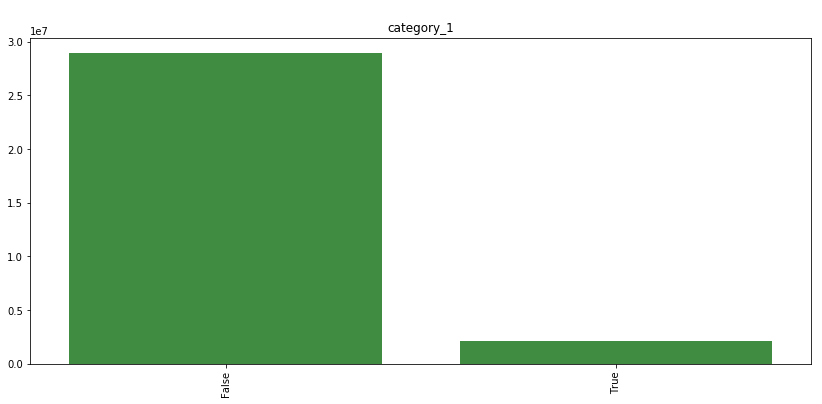

In [29]:
print("There are %d different categories: " % transactions_df['category_1'].nunique())
print(Counter(transactions_df['category_1']))
cat_plot(transactions_df, "category_1")

In [85]:
# Change to boolean
transactions_df = transactions_df.replace({'category_1': {'Y': True, 'N': False}})

#### installments

There are 15 different categories: 
Counter({0: 16333991, 1: 12513700, 2: 721145, 3: 582957, -1: 234081, 4: 194340, 6: 143023, 10: 127726, 5: 125386, 12: 57914, 8: 22029, 7: 11769, 9: 6250, 11: 891, 999: 190})


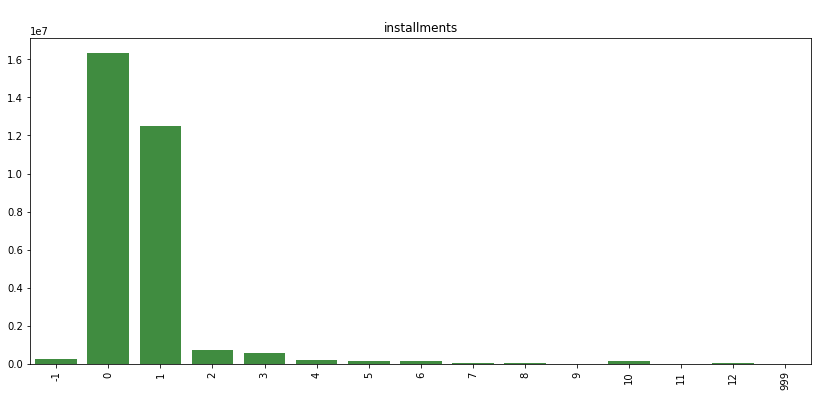

In [30]:
print("There are %d different categories: " % transactions_df['installments'].nunique())
print(Counter(transactions_df['installments']))
cat_plot(transactions_df, "installments")

In [86]:
# Convert 999 to -1, there are too few occurrences to be relevant
transactions_df = transactions_df.replace({'installments': {999: -1}})

<Figure size 1008x432 with 0 Axes>

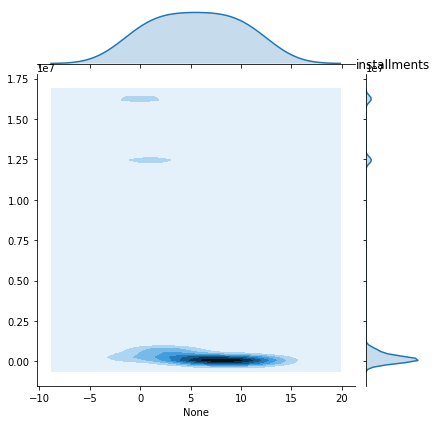

In [45]:
joint_dens_plot(transactions_df, "installments")

#### category_3

There are 3 different categories: 
Counter({'A': 16333991, 'B': 12513700, 'C': 1993620, nan: 234081})


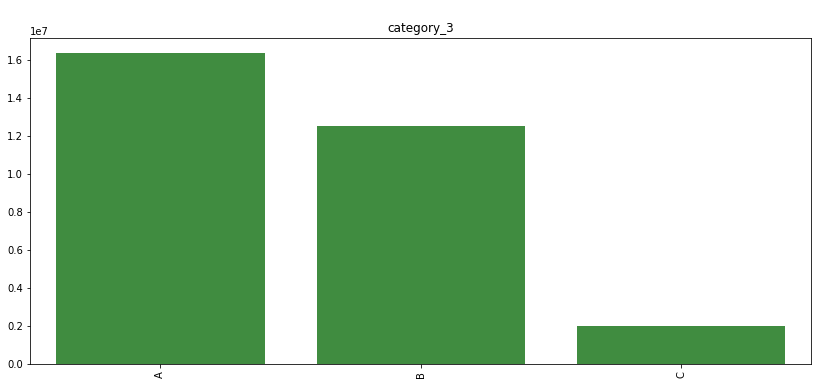

In [33]:
print("There are %d different categories: " % transactions_df['category_3'].nunique())
print(Counter(transactions_df['category_3']))
cat_plot(transactions_df, "category_3")

In [87]:
# fill nans with a fourth category
transactions_df['category_3'].fillna('D', inplace=True)

#### merchant_category_id

In [35]:
print("Historical transactions set has %d different merchant_category_id" % len(set(historical_transactions_df.merchant_category_id.unique())))
print("New transactions set has %d different merchant_category_id" % len(set(new_transactions_df.merchant_category_id.unique())))
print("Number of common merchant_category_id in historical and new transactions set: %d" % (len(set(historical_transactions_df.merchant_category_id.unique()).intersection(set(new_transactions_df.merchant_category_id.unique())))))

Historical transactions set has 327 different merchant_category_id
New transactions set has 314 different merchant_category_id
Number of common merchant_category_id in historical and new transactions set: 310


#### merchant_id

In [36]:
print("Historical transactions set has %d different merchant_id" % len(set(historical_transactions_df.merchant_id.unique())))
print("New transactions set has %d different merchant_id" % len(set(new_transactions_df.merchant_id.unique())))
print("Number of common merchant_id in historical and new transactions set: %d" % (len(set(historical_transactions_df.merchant_id.unique()).intersection(set(new_transactions_df.merchant_id.unique())))))

Historical transactions set has 326312 different merchant_id
New transactions set has 226130 different merchant_id
Number of common merchant_id in historical and new transactions set: 217808


There's nothing with a real sense we can infer about merchant_id missing values. Because they are not so many, the only possibility is to drop them.

In [88]:
# drop the rows where there are missing values in merchant_id
transactions_df.dropna(subset=['merchant_id'], inplace=True)

#### month_lag 
Number of months of delay before payment

There are 16 different categories: 
Counter({-2: 3835910, -1: 3589436, 0: 3404841, -3: 3087434, -4: 2637822, -5: 2364232, -6: 2049613, -7: 1769489, -8: 1427532, -9: 1234466, -10: 1084782, 1: 1014541, -11: 1007695, 2: 922274, -12: 791748, -13: 688880})


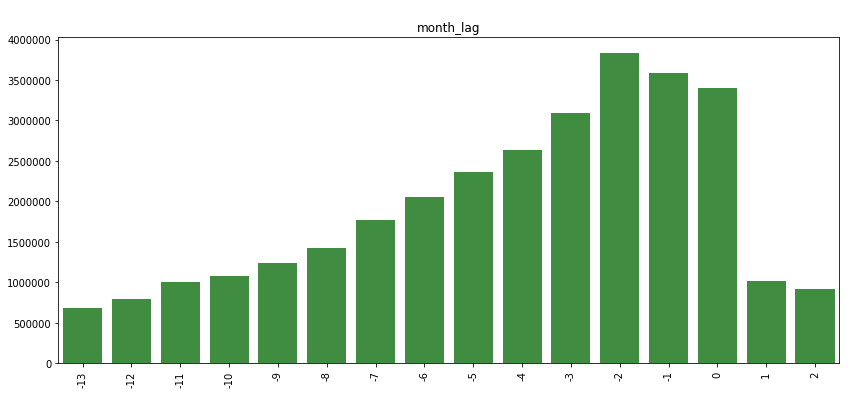

In [46]:
print("There are %d different categories: " % transactions_df['month_lag'].nunique())
print(Counter(transactions_df['month_lag']))
cat_plot(transactions_df, "month_lag")

#### purchase_amount

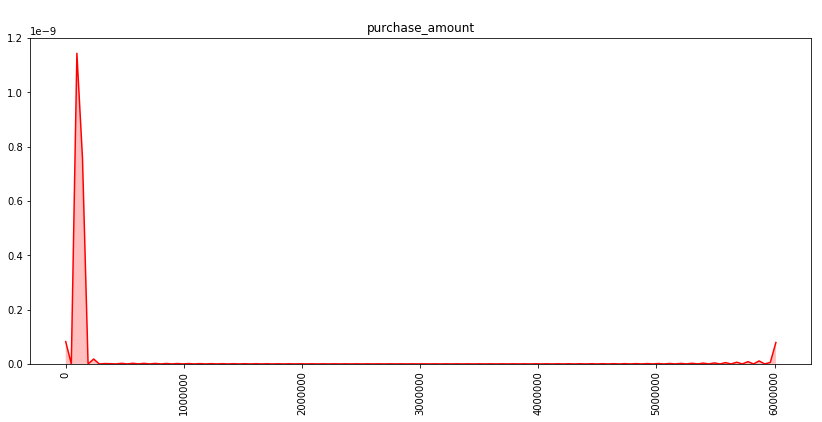

In [60]:
dens_plot(transactions_df, "purchase_amount")

In [48]:
print(min(transactions_df['purchase_amount'].values),max(transactions_df['purchase_amount'].values))
print("There are %d values minor than 0" % len(transactions_df[transactions_df['purchase_amount'] > 100]))

-0.7469078 6010603.9717525


#### purchase_date

In [89]:
# Parse purchase_date to datetime format
purchase_date = pd.to_datetime(transactions_df['purchase_date'], errors='coerce')
transactions_df['purchase_date'] = purchase_date.dt.date
# transactions_df['purchase_month_year'] = purchase_date.dt.to_period('M')

#### category_2

In [90]:
print("There are %d different categories and %d nans" % (transactions_df['category_2'].nunique(), transactions_df['category_2'].isnull().sum()))
print("The range of values goes from %d to %d with jumps of 1" % (min(transactions_df['category_2'].values),max(transactions_df['category_2'].values)))
print("We fill nans with 6")
transactions_df['category_2'].fillna(6.0, inplace=True)

There are 5 different categories and 2753032 nans
The range of values goes from 1 to 5 with jumps of 1
We fill nans with 6


There are 6 different categories: 
Counter({1.0: 16147389, 3.0: 4176501, 5.0: 3960801, 4.0: 2784722, 6.0: 2753032, 2.0: 1088250})


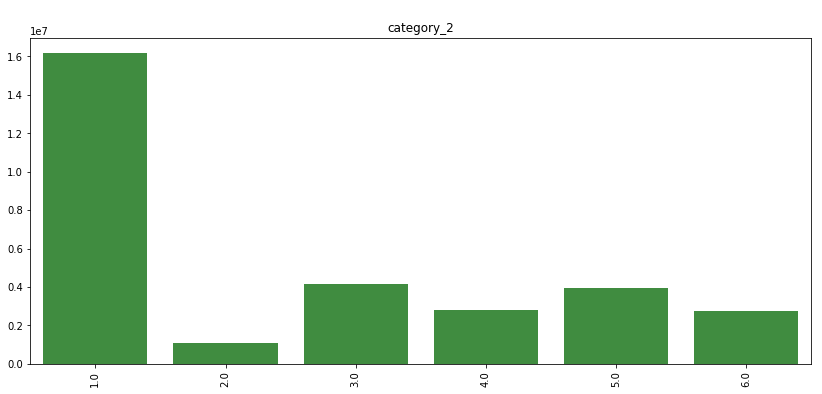

In [91]:
print("There are %d different categories: " % transactions_df['category_2'].nunique())
print(Counter(transactions_df['category_2']))
cat_plot(transactions_df, "category_2")

<Figure size 1008x432 with 0 Axes>

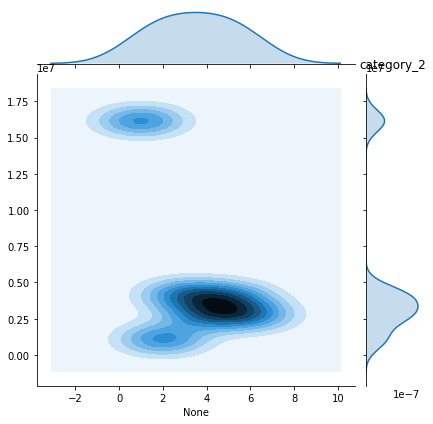

In [92]:
joint_dens_plot(transactions_df, "category_2")

#### state_id

There are 25 different categories: 
Counter({9: 11243470, -1: 2753032, 16: 2271633, 15: 2221411, 5: 1764619, 19: 1286122, 20: 1211058, 22: 1032114, 21: 985124, 4: 899832, 7: 685660, 11: 674140, 13: 671523, 3: 577944, 12: 410875, 18: 405018, 2: 396673, 1: 263925, 10: 239041, 23: 218589, 24: 218021, 14: 181253, 8: 168873, 17: 123164, 6: 7581})


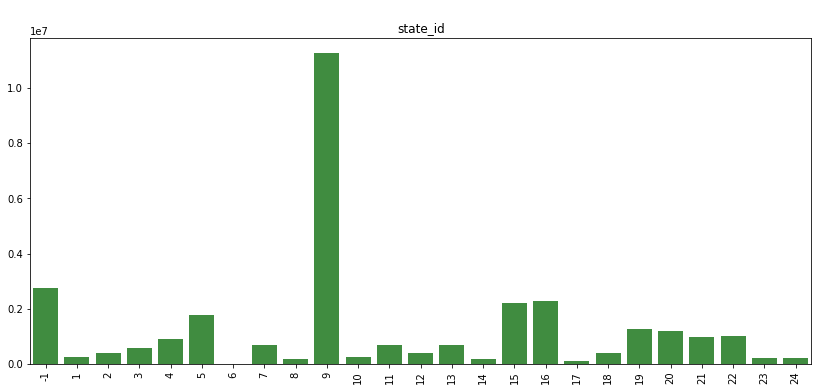

In [93]:
print("There are %d different categories: " % transactions_df['state_id'].nunique())
print(Counter(transactions_df['state_id']))
cat_plot(transactions_df, "state_id")

<Figure size 1008x432 with 0 Axes>

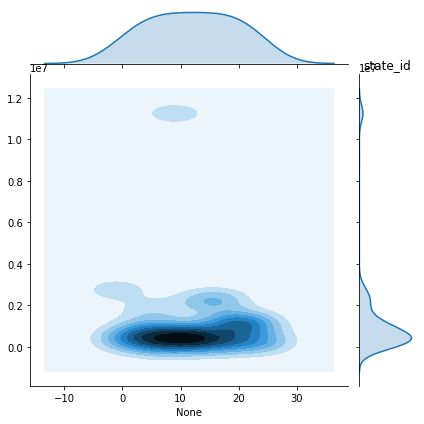

In [94]:
joint_dens_plot(transactions_df, "state_id")

#### subsector_id

There are 41 different categories: 
Counter({33: 5760958, 37: 4844029, 19: 3335545, 29: 2926209, 34: 2918076, 27: 1841089, 16: 1767579, 21: 909106, 7: 760034, 1: 755548, 15: 693416, 8: 552786, 18: 435191, 36: 366375, 20: 335543, 30: 322680, 25: 281103, 39: 278816, 12: 212729, 41: 205299, 22: 190581, 31: 155396, 17: 155307, 32: 144881, 2: 124242, 38: 101379, 3: 94027, 10: 91457, 9: 84085, 4: 63237, 35: 44339, 26: 27160, 13: 25312, 5: 24431, 14: 23211, 23: 20918, 24: 19544, 40: 14104, 11: 2569, -1: 2272, 28: 132})


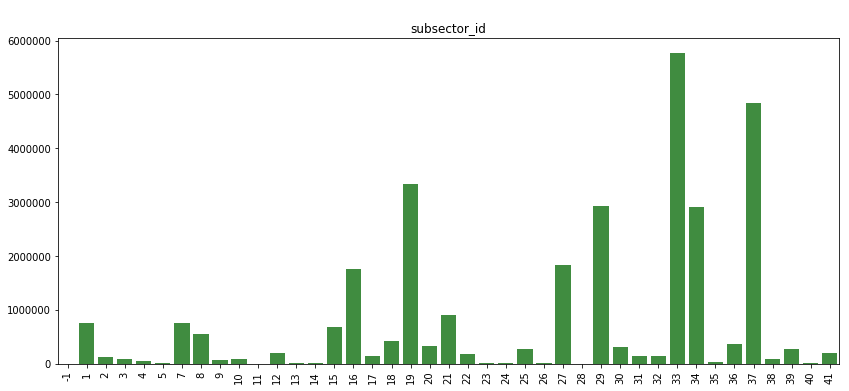

In [95]:
print("There are %d different categories: " % transactions_df['subsector_id'].nunique())
print(Counter(transactions_df['subsector_id']))
cat_plot(transactions_df, "subsector_id")

<Figure size 1008x432 with 0 Axes>

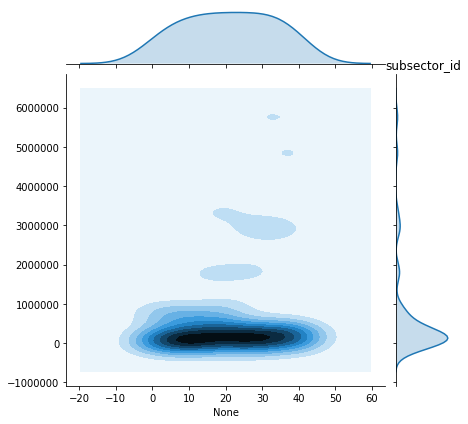

In [96]:
joint_dens_plot(transactions_df, "subsector_id")

### Checkpoint

In [97]:
transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,True,C_ID_4e6213e9bc,88,False,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25,1.0,16,37
1,True,C_ID_4e6213e9bc,88,False,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15,1.0,16,16
2,True,C_ID_4e6213e9bc,88,False,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09,1.0,16,37
3,True,C_ID_4e6213e9bc,88,False,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02,1.0,16,34
4,True,C_ID_4e6213e9bc,88,False,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10,1.0,16,37


In [98]:
transactions_df.isnull().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

### Export cleaned dataframe

In [99]:
transactions_df.to_csv('(1)transactions.csv', index = False)

## Merchants

In [3]:
merchants_df = pd.read_csv("(1)merchant.csv")
merchants_df.shape

(334683, 22)

In [4]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,False,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,False,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,False,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,False,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,False,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,False,-1,5,5.0
3,M_ID_c929bb59af,9514,2,20,-0.057471,-0.057471,False,E,E,69667.00,...,69667.00,1.000000,3,69667.00,1.000000,3,False,-1,20,5.0
4,M_ID_dd3ae3de10,30534,278,37,-0.057471,-0.057471,False,E,E,5180.00,...,9830.00,4.166667,6,15826.00,5.600000,10,True,11,23,2.0


In [ ]:
gdf = historical_transactions_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [ ]:
merchants_df.head()